<a href="https://colab.research.google.com/github/sarcar/kmicrograd/blob/main/kMicrogradColab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = lambda x: 3*x**2 - 2*x + 5
print(f(3.0))

26.0


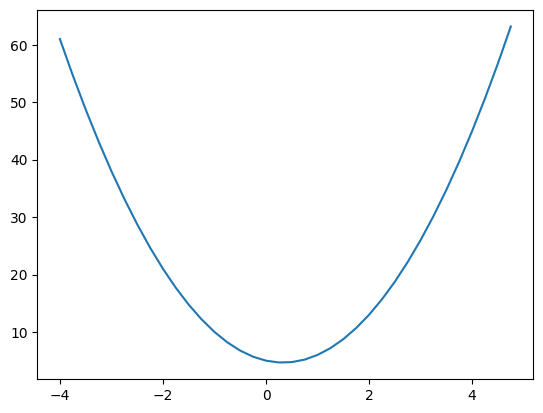

In [3]:
xs = np.arange(-4, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [4]:
# Let us find the slope at x = 3.4
h = 0.0000000000001
x = 1/3.0
(f(x + h) - f(x))/h

0.0

In [5]:
a = 3.0
b = -2.0
c = 4.0
h = 0.0001

y1 = a * b + c
c += h
y2 = a * b + c
slope = (y2 - y1) / h
print(f'Slope = {slope}')

Slope = 0.9999999999976694


In [6]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

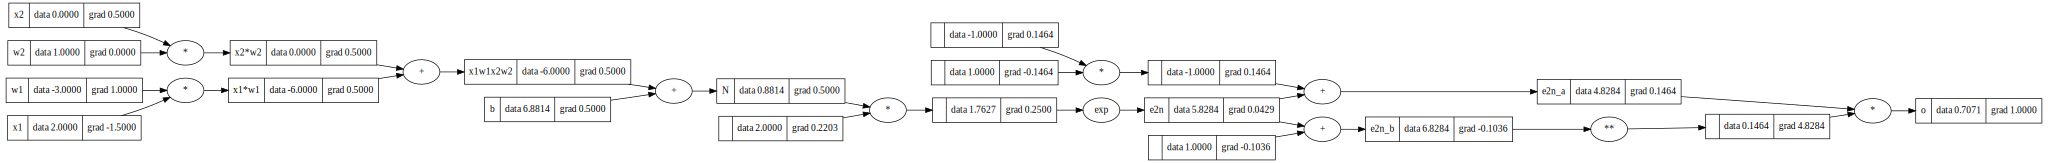

In [7]:
class Value:
    
    def __init__(self, data, children=(), op='', label=''):
        # Only supports int or float data
        assert(isinstance(data, int) or isinstance(data, float))

        self.data = data
        self.grad = 0.0
        self._prev = set(children)
        self._op = op
        self.label = label
        self._backward = lambda : None

    def details(self):
        s  = f"Label={self.label},Op={self._op},data={self.data:.5f},grad={self.grad:.5f}"
        return s

    def __repr__(self):
        if self.label:
            return f"Value({self.label} => {self.data:.5f})"
        else:
            return f"Value({self.data:.5f})"
        
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad  += 1 * out.grad
            other.grad += 1 * out.grad
            # print(f"{self.details()}  | {other.details()}")
        
        out._backward = _backward
        return out
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad  += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        other_inverse = other.__pow__(-1)
        return self * other_inverse
   
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return self + (-other) 

    def __iadd__(self, other): # in-place addition
        if isinstance(other, Value):
            self.data += other.data
        else:
            self.data += other
        return self

    def __isub__(self, other): # in-place subtraction
        if isinstance(other, Value):
            self.data -= other.data
        else:
            self.data -= other
        return self
        
    def tanh(self):
        e2x = math.exp(2*self.data)
        t = (e2x - 1) / (e2x + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - (out.data ** 2)) * out.grad # this "out.grad" is computed not when tanh is called but when _backward() is called
            
        out._backward = _backward  # The function pointer, not the function's return value
        return out

    def exp(self): # called as self.exp(); which will give us e^d
        out = Value(math.exp(self.data),(self,),'exp')

        def _backward():
            self.grad += math.exp(self.data) * out.grad # this "out.grad" is computed not when exp is called but when _backward() is called

        out._backward = _backward
        return out

    def __pow__(self, n): # called as self ^ n, division is a special case with n = -1
        out = Value(self.data ** n, (self,),'**')
        def _backward():
            self.grad += n * (self.data ** (n - 1)) * out.grad # this "out.grad" is computed not when pow is called but when _backward() is called
        out._backward = _backward
        return out


    def __radd__(self, other):
        return Value(other) + self

    def __rmul__(self, other):
        return Value(other) * self


    def backward(self):
 
        # Topological sort
        topo = []
        visited = set()
        
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        rev_topo = reversed(topo)
                
        for node in rev_topo:
            # print(f"Clearing grad of node : {node.details()}")
            node.grad = 0
        
        self.grad = 1
        for node in reversed(topo):
            node._backward()


x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
b = Value(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label='x1*w1'
x2w2 = x2 * w2; x2w2.label='x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label='x1w1x2w2'
n = x1w1x2w2 + b; n.label = 'N'

# ---
# o = n.tanh(); o.label = 'o'
# ---

"""
o.grad = 1.0
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()
x1._backward()
x2._backward()
w1._backward()
w2._backward()
# ---
"""

# ----
e2n = (n * 2).exp(); e2n.label = 'e2n'
e2n_a = e2n - 1; e2n_a.label = 'e2n_a'
e2n_b = e2n + 1; e2n_b.label = 'e2n_b'
o = e2n_a / e2n_b; o.label = 'o'
# ----

o.backward()
draw_dot(o)




In [8]:
print(o)
assert(x1.grad == -1.5)
assert(w1.grad == 1.0)
assert(x2.grad == 0.5)
assert(w2.grad == 0)
assert(math.floor(o.data * 10000) == 7071) # forward pass

Value(o => 0.70711)


In [9]:
import random
class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)] 
        self.b = Value(random.uniform(-1,1))

    def __call__(self, xin):
        assert(len(xin) == len(self.w))
        act = sum(x * w for x,w in zip(xin, self.w)) # + self.b
        out = act.tanh()
        return out

    def params(self): # return a list of all parameters
        return self.w + [self.b]
        
class Layer:
    def __init__(self,nin,nout): # nout = number of nodes in that layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, xin):
        out = [n(xin) for n in self.neurons]
        return out[0] if len(out) ==1 else out

    def params(self):
        params = []
        [params.extend(n.params()) for n in self.neurons]
        return params

class MLP:
    def __init__(self, l0, l):
        s = [l0] + l
        self.layers = [Layer(s[i],s[i+1]) for i in range(len(s)-1)] 

    def __call__(self, x0):
        x = x0
        for layer in self.layers:
            x = layer(x)
        return x

    def params(self):
        params = []
        [params.extend(layer.params()) for layer in self.layers]
        return params

In [10]:
"""y = Neuron(3)
h = y([3,-1,2.4])
y.params()

layer = Layer(3, 4)
l = layer([4,0,1])
layer.params()"""

net = MLP(3, [4,4,1])
xs = [[2., 3., -1.],
    [3., -1., 0.5],
    [0.5, 1., 1.],
    [1., 1., -1.]]

ys = [1.0, -1.0, -1.0, 1.0]  # desired target, binary classification

In [11]:
allparams = net.params()
print(type(allparams), len(allparams))
prev_loss = 0
loss_dir = "None"

<class 'list'> 41


In [12]:
iteration = 0
loss_floor = 1e-5
loss = Value(loss_floor + 100)
learning_rate = 0.4
x_iter = []
y_iter = []

while (loss.data > loss_floor):
    iteration += 1
    ypred = [net(x) for x in xs]
    loss = sum((yest-y)**2 for yest, y in zip(ypred,ys))
    if loss.data < prev_loss:
        loss_dir = "Decrease"
    else:
        loss_dir = "Increase"
    if iteration % 300 == 0:
        print(f"{iteration}: Loss = {loss.data}, Loss direction = {loss_dir}")
        x_iter.append(iteration)
        y_iter.append(loss.data)
    prev_loss = loss.data
    for p in allparams:
        p.grad = 0.0
    loss.backward()
    for p in allparams:
        p -= (learning_rate * p.grad)

print(f"Final loss = {loss.data}")
print(ypred)      

300: Loss = 0.00024072299452704415, Loss direction = Decrease
600: Loss = 0.0001175509191265105, Loss direction = Decrease
900: Loss = 7.68618297019127e-05, Loss direction = Decrease
1200: Loss = 5.678347588991189e-05, Loss direction = Decrease
1500: Loss = 4.487812842833089e-05, Loss direction = Decrease
1800: Loss = 3.702244737777056e-05, Loss direction = Decrease
2100: Loss = 3.146146820230598e-05, Loss direction = Decrease
2400: Loss = 2.7323733437613247e-05, Loss direction = Decrease
2700: Loss = 2.412824524406368e-05, Loss direction = Decrease
3000: Loss = 2.158815354415892e-05, Loss direction = Decrease
3300: Loss = 1.9521945701879598e-05, Loss direction = Decrease
3600: Loss = 1.7809247668940473e-05, Loss direction = Decrease
3900: Loss = 1.636713111966332e-05, Loss direction = Decrease
4200: Loss = 1.5136632579396012e-05, Loss direction = Decrease
4500: Loss = 1.4074697858775388e-05, Loss direction = Decrease
4800: Loss = 1.314916685042225e-05, Loss direction = Decrease
5100: 

In [13]:
# TODO : Get the code to run on GPU
# TODO : Do a separate notebook no MatPlotlib
# TODO : Do a separate notebook on Python basics


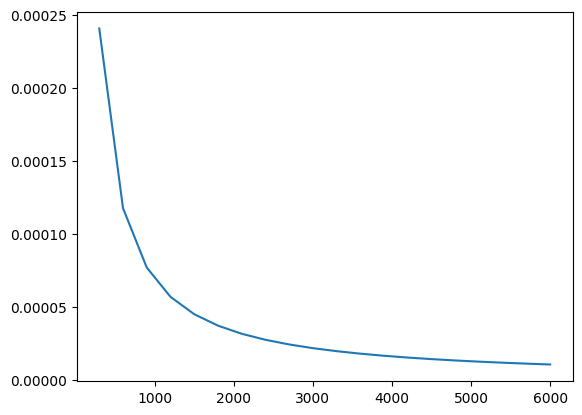

In [14]:
plt.plot(x_iter,y_iter)